In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive', force_remount = True)
path = 'gdrive/My Drive/AML/loan.csv'
df = pd.read_csv(path)

In [ ]:
df.loan_status.value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

In [ ]:
df1 = df[(df['loan_status'] == 'Fully Paid')|(df['loan_status'] == 'Charged Off')]

EDA


1. Missing Data

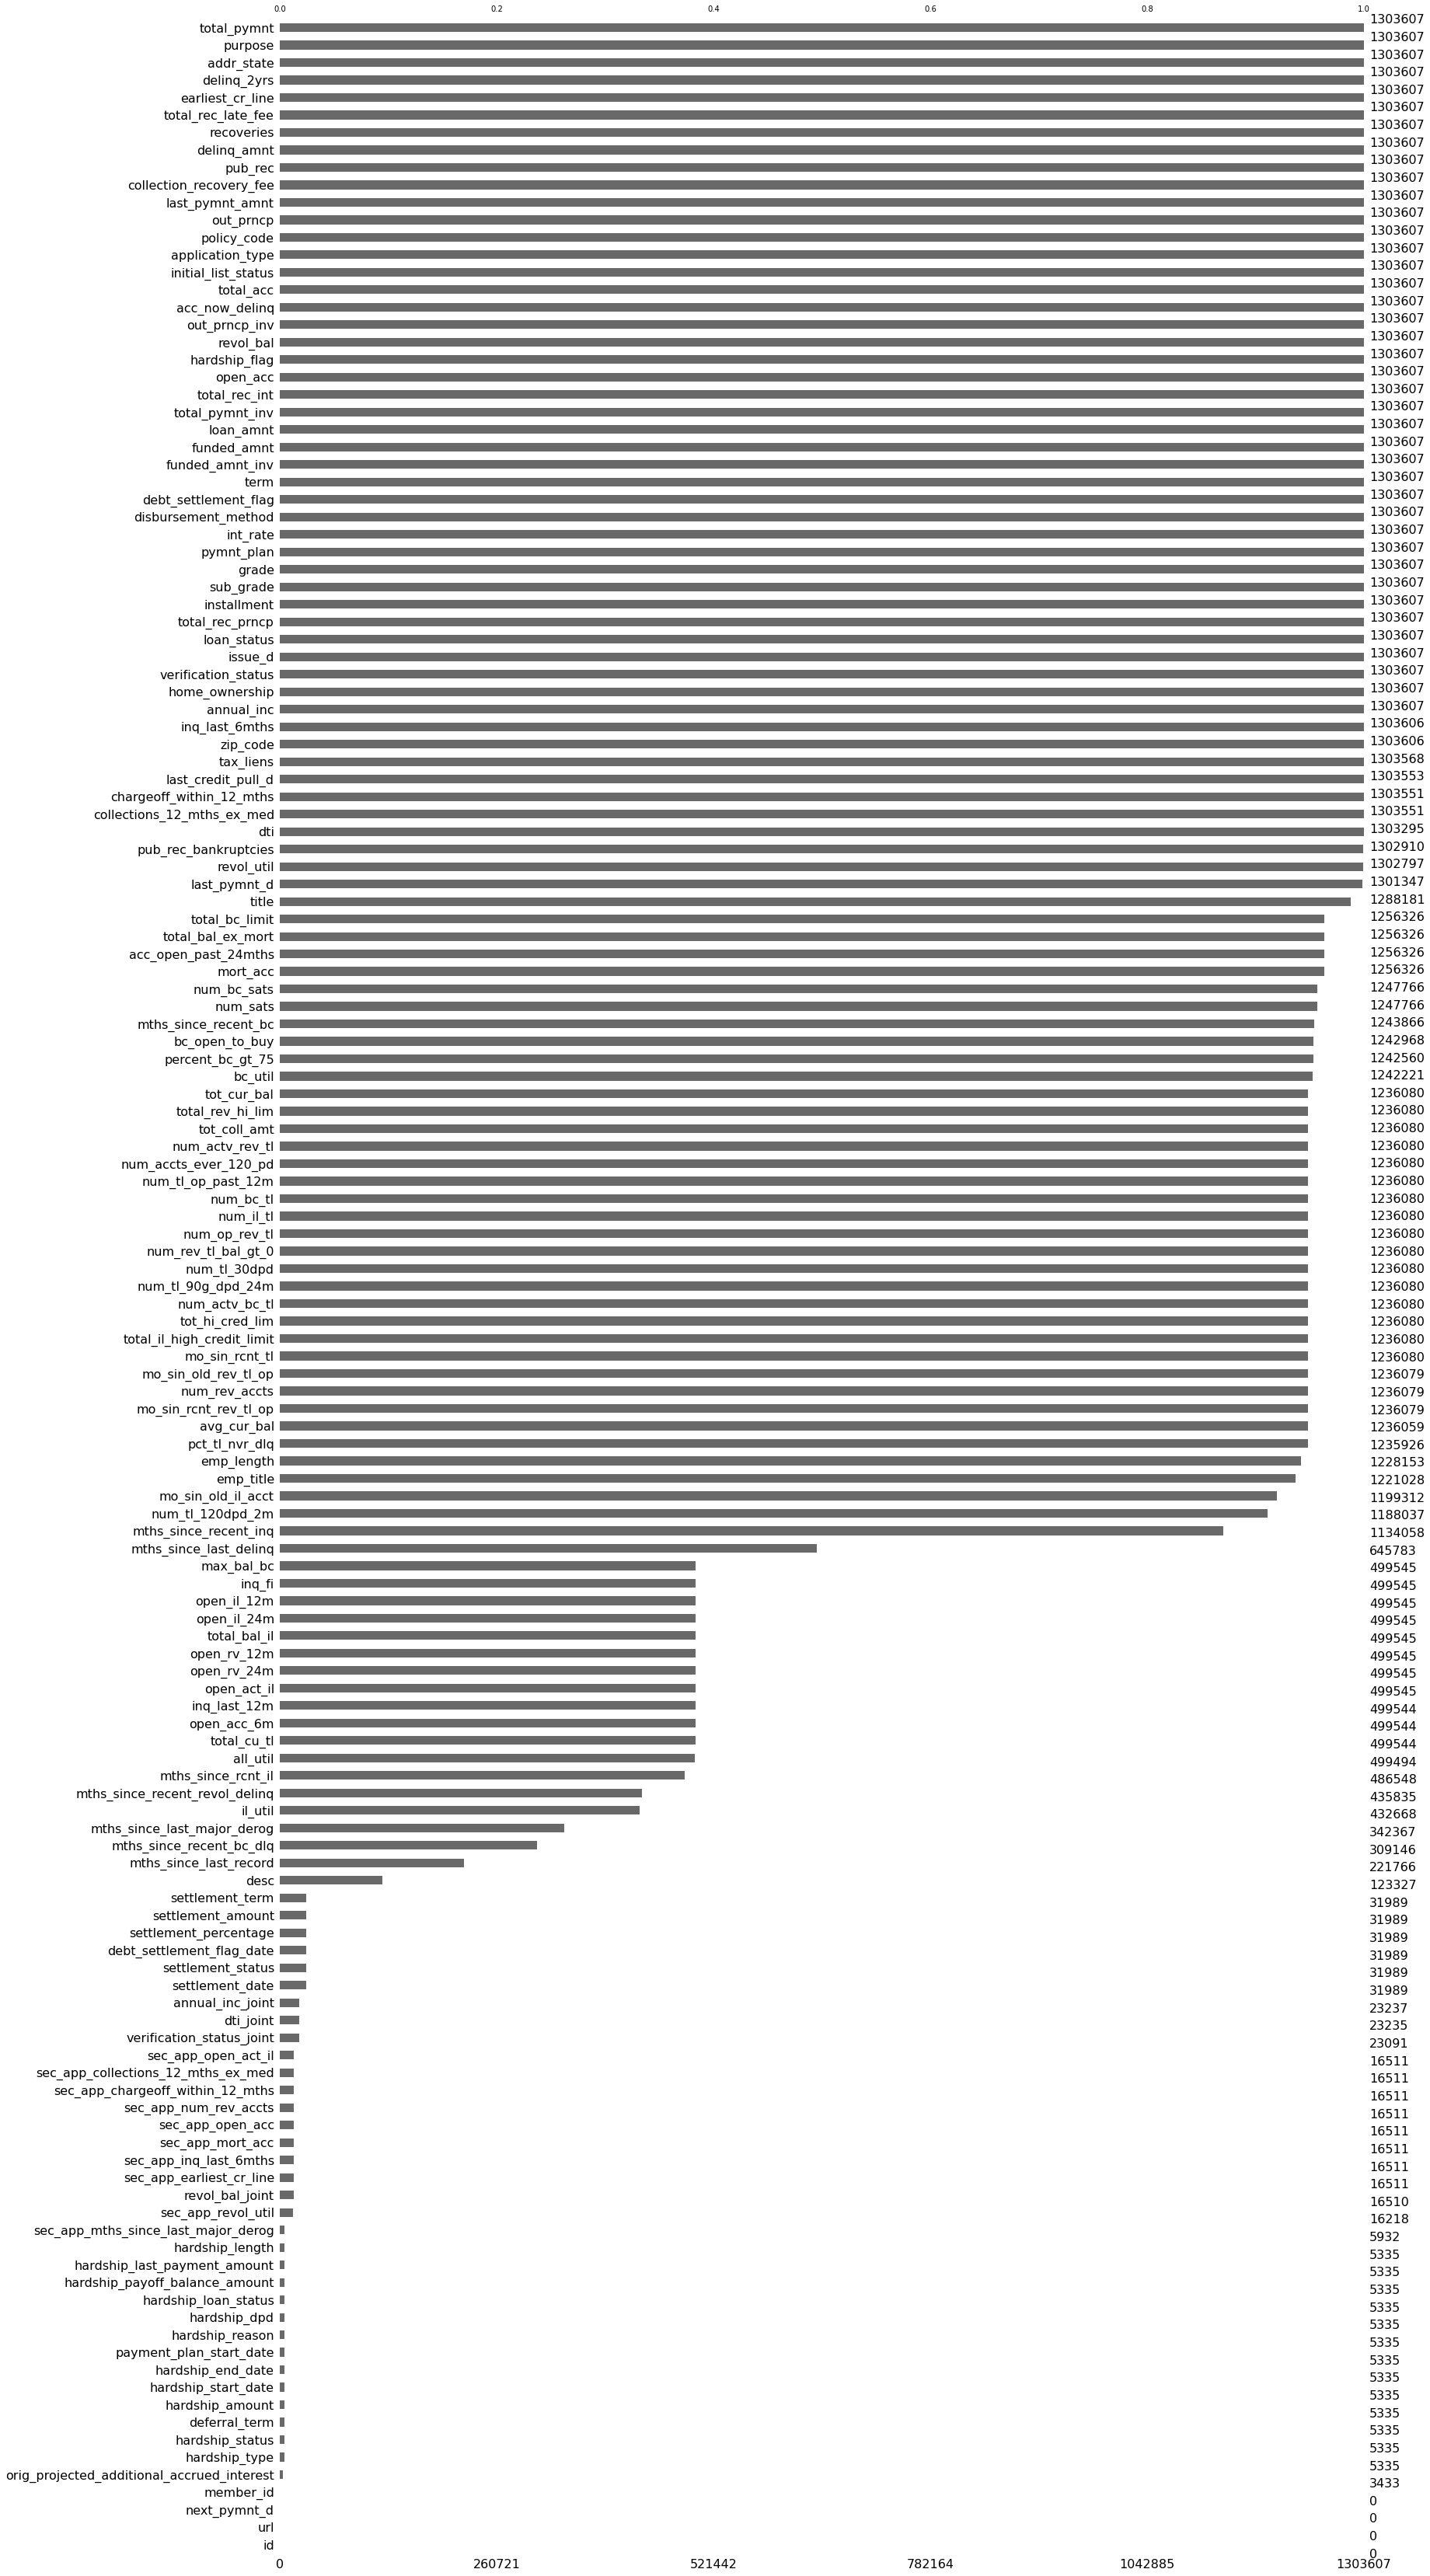

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt

msno.bar(df1, sort = 'ascending')
plt.show()

2. Y disttribution


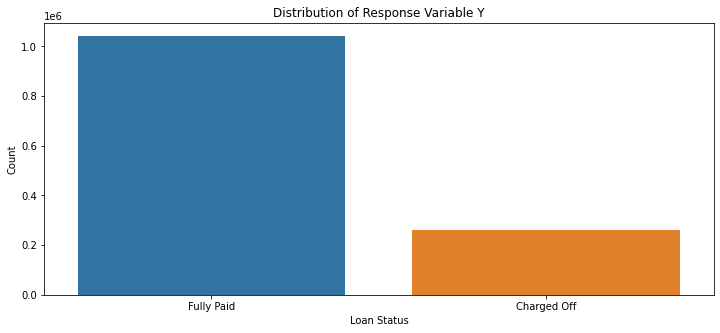

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 5))
sns.countplot(x = 'loan_status',  data = df1, ax = ax)
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Distribution of Response Variable Y')
plt.show()


3. Loan Amount

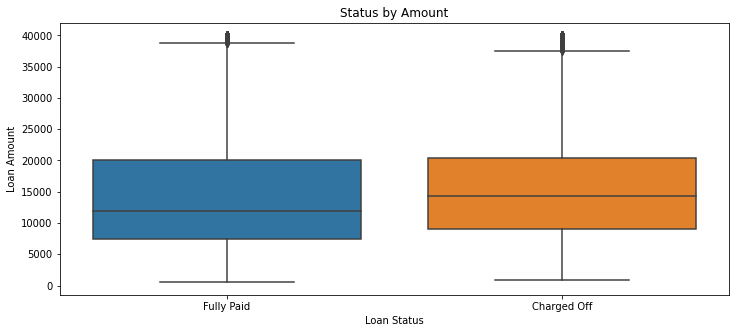

In [ ]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.boxplot(x = 'loan_status', y = 'loan_amnt', data = df1, ax = ax)
plt.xlabel('Loan Status')
plt.ylabel('Loan Amount')
plt.title('Status by Amount')
plt.show()

4. Distribution by over other categorical variables

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


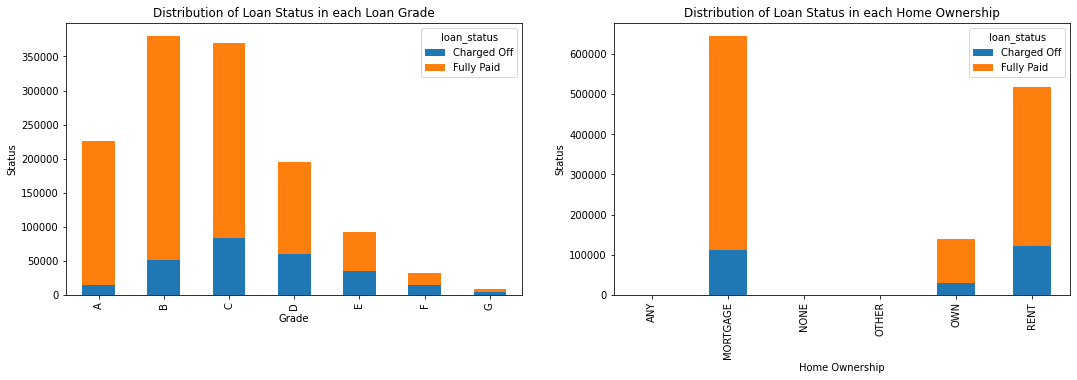

In [ ]:
tmp = df1[['loan_status', 'grade']]
tmp['count'] = 1
tmp = tmp.pivot_table(values = 'count', index = 'grade', columns='loan_status', aggfunc = 'sum')

fig, ax = plt.subplots(1, 2, figsize = (18, 5))
tmp.plot(kind = 'bar', stacked = True, ax = ax[0])
ax[0].set_xlabel('Grade')
ax[0].set_ylabel('Status')
ax[0].set_title('Distribution of Loan Status in each Loan Grade')

tmp1 = df1[['loan_status', 'home_ownership']]
tmp1['count'] = 1
tmp1 = tmp1.pivot_table(values = 'count', index = 'home_ownership', columns = 'loan_status', aggfunc = 'sum')

tmp1.plot(kind = 'bar', stacked = True, ax = ax[1])
ax[1].set_xlabel('Home Ownership')
ax[1].set_ylabel('Status')
ax[1].set_title('Distribution of Loan Status in each Home Ownership')

plt.show()

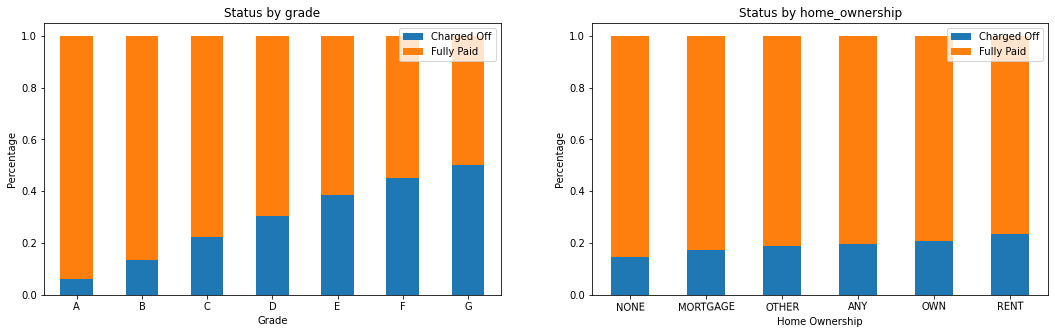

In [ ]:
import numpy as np
fig, ax = plt.subplots(1,2, figsize = (18, 5))

df2=df1.groupby(['grade','loan_status'])['dti'].count()
plot = df2.unstack()
plot_percentage=plot.transpose().div(np.sum(plot,axis=1)).transpose()
plot_percentage.sort_values(by=['Charged Off'], inplace=True)
plot_percentage.plot(kind='bar', stacked=True, rot=1, title="Status by grade", ax = ax[0])
ax[0].set_ylabel('Percentage')
ax[0].set_xlabel('Grade')
ax[0].legend(loc="upper right")

df2=df1.groupby(['home_ownership','loan_status'])['dti'].count()
plot = df2.unstack()
plot_percentage=plot.transpose().div(np.sum(plot,axis=1)).transpose()
plot_percentage.sort_values(by=['Charged Off'], inplace=True)
plot_percentage.plot(kind='bar', stacked=True, rot=1, title="Status by home_ownership", ax = ax[1])
ax[1].set_ylabel('Percentage')
ax[1].set_xlabel('Home Ownership')
ax[1].legend(loc="upper right")

A. Handle Missing Data (threshold = 0.1)

In [ ]:
amount_missing = pd.DataFrame(df1.isnull().sum()/len(df1))
amount_missing.columns = ['missing_prop']
cols = amount_missing[amount_missing['missing_prop'] < 0.1].index
subset_df = df1[cols].dropna(axis = 0)

B. Choose a subset of features to focus on

In [ ]:
subset_df['loan_status_coded'] = subset_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
corr = subset_df.corr()

5. Heatmap of correlation between numerical variables

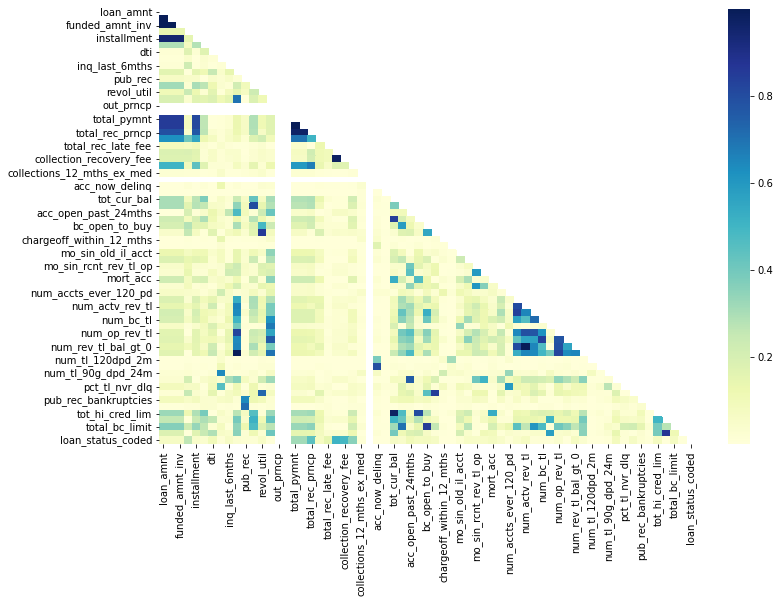

In [ ]:
import numpy as np
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (12, 8))
sns.heatmap(abs(corr), ax = ax, mask= mask, cmap = "YlGnBu")
plt.show()

B.1 Further Remove highly correlated features

In [ ]:
#subset_corr = subset_df[top50_n_high_var].corr()
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
subset2 = subset_df.drop(to_drop, axis = 1)

B.2 Select top 30 features that are highly correlated with response variable

In [ ]:
corr = subset2.corr()
top30_correlated = abs(corr['loan_status_coded']).sort_values(ascending = False)[:30].index

In [ ]:
top30_correlated

Index(['loan_status_coded', 'recoveries', 'last_pymnt_amnt', 'int_rate',
       'total_rec_late_fee', 'acc_open_past_24mths', 'dti',
       'num_tl_op_past_12m', 'bc_open_to_buy', 'mort_acc', 'total_rec_int',
       'loan_amnt', 'tot_cur_bal', 'inq_last_6mths', 'mo_sin_rcnt_tl',
       'mo_sin_old_rev_tl_op', 'revol_util', 'mo_sin_rcnt_rev_tl_op',
       'mths_since_recent_bc', 'num_actv_bc_tl', 'annual_inc', 'open_acc',
       'mo_sin_old_il_acct', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal',
       'delinq_2yrs', 'num_bc_tl', 'num_accts_ever_120_pd',
       'collections_12_mths_ex_med'],
      dtype='object')

B.2 Features with high variance among the 30

In [ ]:
top30_n_high_var = subset_df[top30_correlated].var().sort_values(ascending = False) > 1
top30_n_high_var = top30_n_high_var[top30_n_high_var == True].index

Remaining Numerical Features

In [ ]:
subset2[top30_n_high_var].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1056242 entries, 100 to 2260664
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   tot_cur_bal            1056242 non-null  float64
 1   annual_inc             1056242 non-null  float64
 2   revol_bal              1056242 non-null  int64  
 3   bc_open_to_buy         1056242 non-null  float64
 4   loan_amnt              1056242 non-null  int64  
 5   last_pymnt_amnt        1056242 non-null  float64
 6   total_rec_int          1056242 non-null  float64
 7   recoveries             1056242 non-null  float64
 8   mo_sin_old_rev_tl_op   1056242 non-null  float64
 9   mo_sin_old_il_acct     1056242 non-null  float64
 10  mths_since_recent_bc   1056242 non-null  float64
 11  revol_util             1056242 non-null  float64
 12  mo_sin_rcnt_rev_tl_op  1056242 non-null  float64
 13  total_rec_late_fee     1056242 non-null  float64
 14  dti             

In [ ]:
num_features = list(top30_n_high_var)
left_df, right_df = subset2[subset2['loan_status'] == 'Fully Paid'], subset2[subset2['loan_status'] == 'Charged Off']

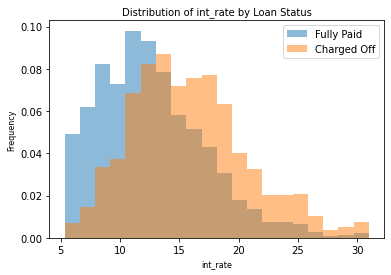

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(left_df['int_rate'], bins=20, alpha = 0.5, label = 'Fully Paid', density=True)
plt.hist(right_df['int_rate'], bins=20, alpha = 0.5, label = 'Charged Off', density=True)
plt.title('Distribution of int_rate by Loan Status', fontsize = 10)
plt.xlabel('int_rate', fontsize = 8)
plt.ylabel('Frequency', fontsize = 8)
plt.legend(labels = ['Fully Paid', 'Charged Off'])
plt.show()

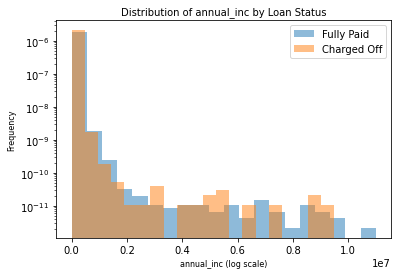

In [ ]:
plt.hist(left_df['annual_inc'], bins=20, alpha = 0.5, label = 'Fully Paid', density=True, log=True)
plt.hist(right_df['annual_inc'], bins=20, alpha = 0.5, label = 'Charged Off', density=True, log=True)
plt.title('Distribution of annual_inc by Loan Status', fontsize = 10)
plt.xlabel('annual_inc (log scale)', fontsize = 8)
plt.ylabel('Frequency', fontsize = 8)
plt.legend(labels = ['Fully Paid', 'Charged Off'])
plt.show()

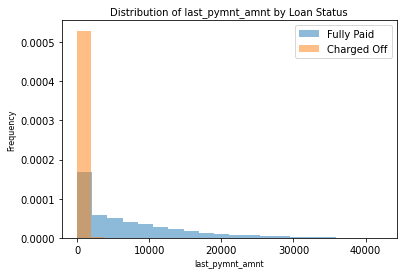

In [ ]:
plt.hist(left_df['last_pymnt_amnt'], bins=20, alpha = 0.5, label = 'Fully Paid', density=True)
plt.hist(right_df['last_pymnt_amnt'], bins=20, alpha = 0.5, label = 'Charged Off', density=True)
plt.title('Distribution of last_pymnt_amnt by Loan Status', fontsize = 10)
plt.xlabel('last_pymnt_amnt', fontsize = 8)
plt.ylabel('Frequency', fontsize = 8)
plt.legend(labels = ['Fully Paid', 'Charged Off'])
plt.show()

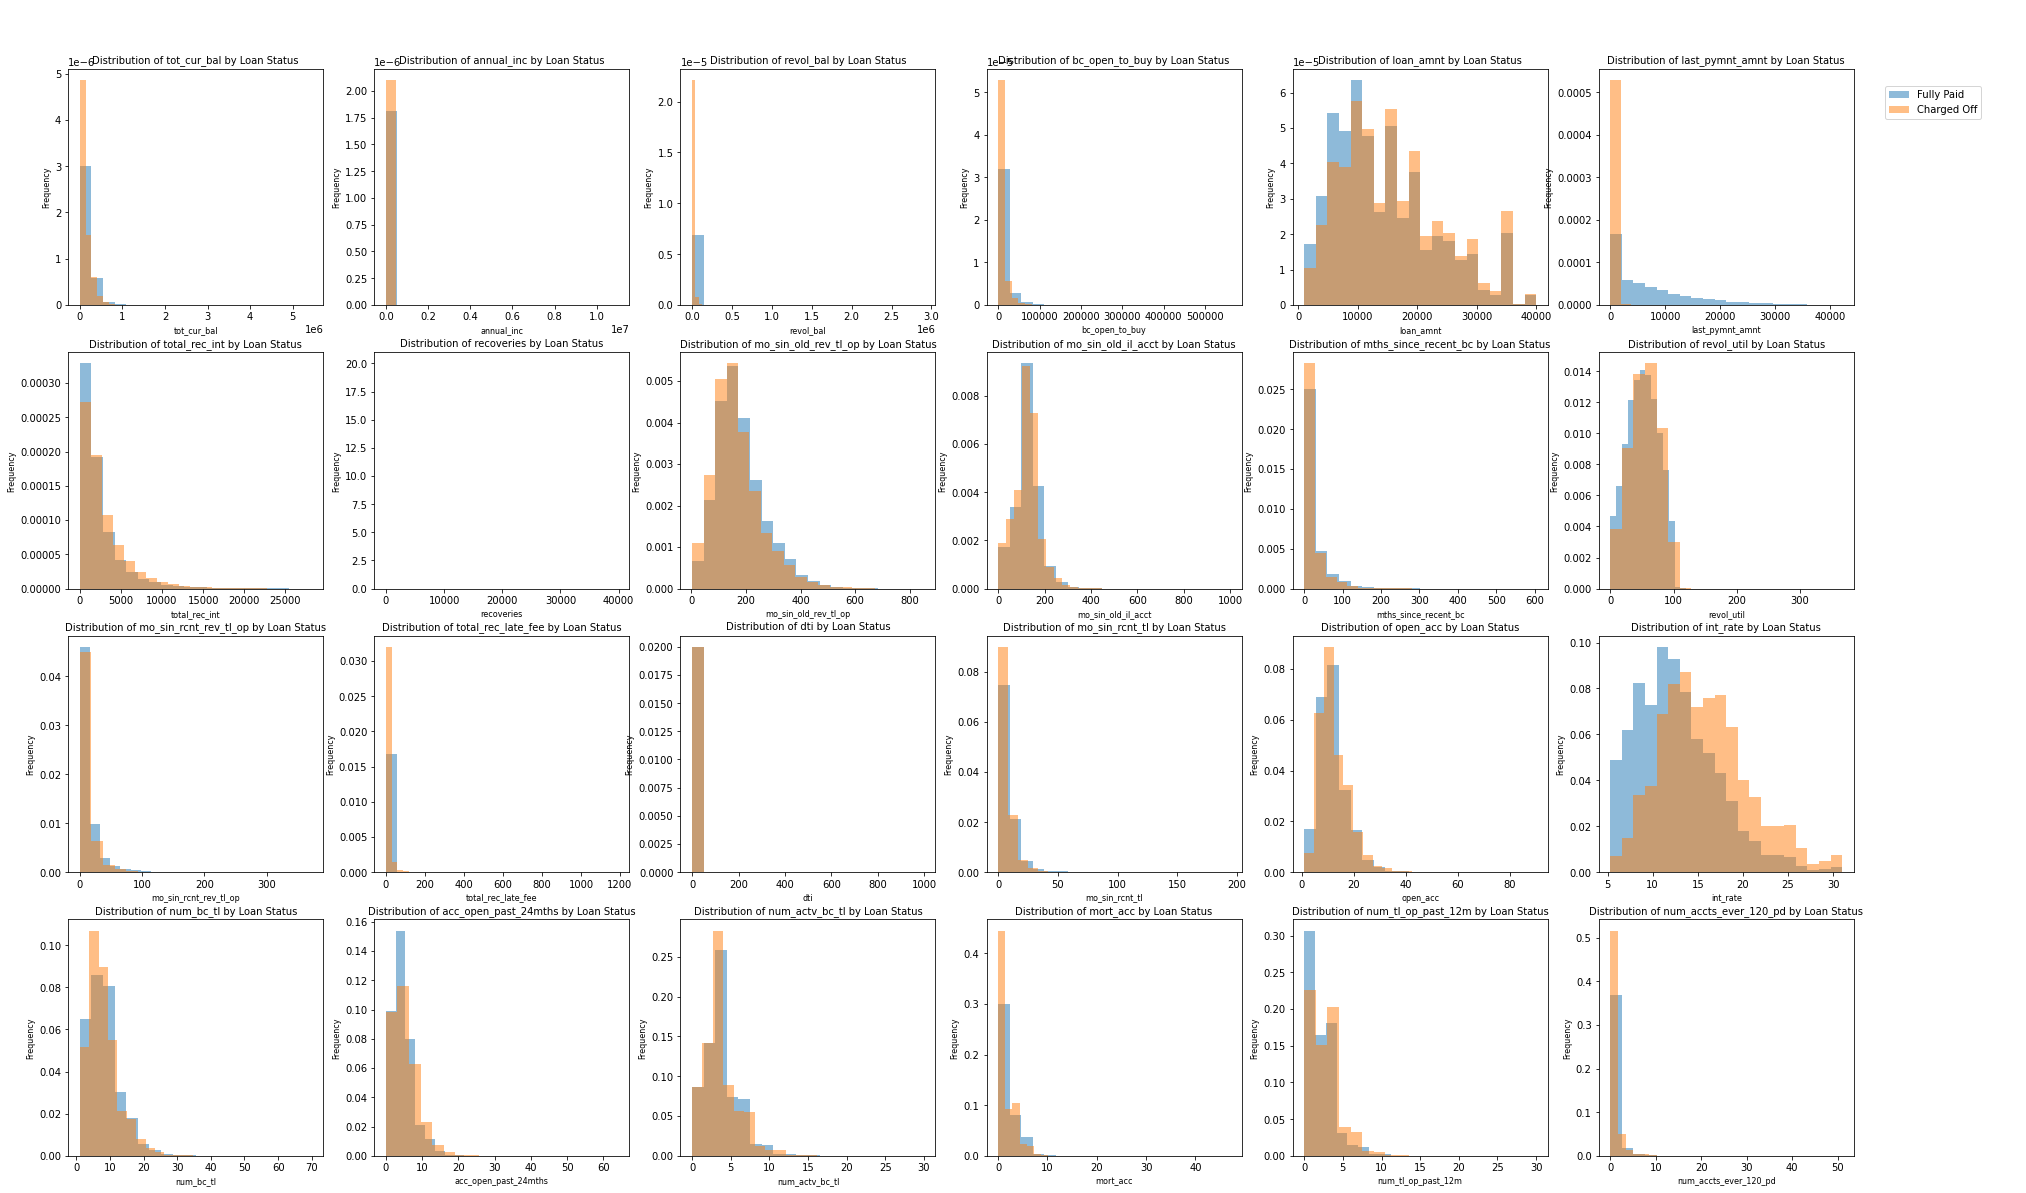

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(4, 6, figsize = (32, 20))

ax = ax.ravel() 
i = 0
for col in num_features:
  ax[i].hist(left_df[col], bins=20, alpha = 0.5, label = 'Fully Paid', density=True)
  ax[i].hist(right_df[col], bins=20, alpha = 0.5, label = 'Charged Off', density=True)
  ax[i].set_title('Distribution of %s by Loan Status'%col, fontsize = 10)
  ax[i].set_xlabel(col, fontsize = 8)
  ax[i].set_ylabel('Frequency', fontsize = 8)
  i+=1
fig.legend(labels = ['Fully Paid', 'Charged Off'], loc = (0.93, 0.9))
plt.show()

3. Selecting categorical features

In [ ]:
cat_features_sub = ['term', 'sub_grade', 'last_credit_pull_d', 'home_ownership',
                    'verification_status', 'zip_code', 'purpose', 'earliest_cr_line', 'loan_status']
final_set = subset2[list(num_features) + cat_features_sub]

In [ ]:
final_set.to_csv('feature_selected.csv')
!cp feature_selected.csv "gdrive/My Drive/AML/"

In [ ]:
from sklearn.model_selection import train_test_split

X = final_set.drop(['loan_status'], axis = 1)
y = final_set['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

X_dev, X_test, y_dev, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, stratify = y_dev, test_size = 0.2, random_state = 84)


In [ ]:
print(X_dev.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(844993, 32)
(675994, 32)
(168999, 32)
(211249, 32)


In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder


sc = StandardScaler()
enc = OneHotEncoder()

num_features = 
cat_features_onehot = 
cat_features_ord = 
preprocess = male_column_transformer(
    (sc, num_features),
    (enc, cat_features_onehot),
    (ord, cat_features_ord)
)

Continued in the next notebook...